In [6]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [3]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 1000
Número de ecgs que eram pra ser processados: 1000
Número total de traçados processados: 1000


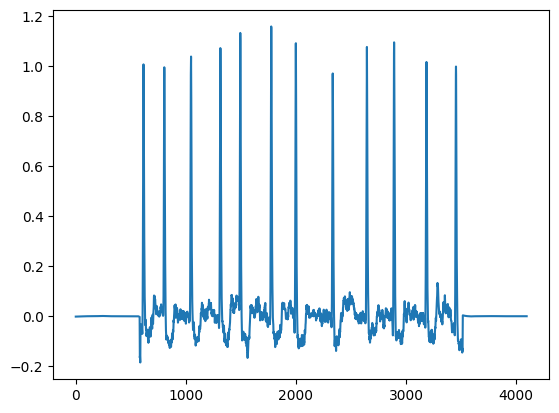

In [41]:
X = carregar_ecgs(normal=0,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=1000,filtrado=True)

plt.plot(X[0][0])

In [42]:
import cupy as cp
import torch
import neurokit2 as nk
from tqdm import tqdm

# Função para detectar picos R
def detect_r_peaks(ecg_signal, sampling_rate=1000):
    _, r_peaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Função para extrair um batimento cardíaco
def extract_single_heartbeat(ecg_signal, r_peak, window):
    start = max(0, r_peak - window)
    end = min(len(ecg_signal), r_peak + window)
    return ecg_signal[start:end]

# Função para criar o grafo de visibilidade
def criar_grafo_visibilidade_pt(vetor):
    if not isinstance(vetor, cp.ndarray):
        vetor = cp.array(vetor)

    n = len(vetor)
    src_list = []
    dst_list = []

    for i in range(n):
        valor_i = vetor[i]
        indices = cp.arange(i + 1, n)
        if len(indices) == 0:
            continue

        slopes = (vetor[indices] - valor_i) / (indices - i)
        slopes_cpu = cp.asnumpy(slopes)

        max_slope = -float('inf')
        for offset, s in enumerate(slopes_cpu):
            if s > max_slope:
                max_slope = s
                j = i + 1 + offset
                src_list.append(i)
                dst_list.append(j)

    src_t = torch.tensor(src_list, dtype=torch.long)
    dst_t = torch.tensor(dst_list, dtype=torch.long)

    return {'src': src_t, 'dst': dst_t}

# Função principal para processar apenas um batimento por ECG
def processar_um_batimento_por_ecg(X, window=500, sampling_rate=1000, output_path='grafos_visibilidade.pt'):
    todos_grafos = []
    vetores_batimentos = []
    n_ecgs = X.shape[0]

    for idx in tqdm(range(n_ecgs), desc="Processando ECGs"):
        ecg_signal = X[idx, 0, :]  # Seleciona a lead 0 do ECG atual
        r_peaks = detect_r_peaks(ecg_signal, sampling_rate=sampling_rate)

        if len(r_peaks) > 2:  # Seleciona o terceiro pico R
            r_peak = r_peaks[2]
            batimento = extract_single_heartbeat(ecg_signal, r_peak, window)
            grafo = criar_grafo_visibilidade_pt(batimento)
            todos_grafos.append(grafo)
            vetores_batimentos.append(batimento)
        else:
            print(f"Menos de 3 picos R encontrados para o ECG {idx}.")

    torch.save({'grafos': todos_grafos, 'vetores': vetores_batimentos}, output_path)
    print(f"Grafos de visibilidade de um batimento por ECG foram salvos em {output_path}.")

# Exemplo de uso
if __name__ == "__main__":
    # Substitua X pela sua estrutura contendo múltiplos ECGs no formato (n_ecgs, leads, pontos)
    X = X  # Exemplo de dado sintético

    processar_um_batimento_por_ecg(X, window=500, output_path='af.pt')


Processando ECGs:   0%|          | 3/1000 [00:00<01:46,  9.36it/s]

Menos de 3 picos R encontrados para o ECG 1.


Processando ECGs:   2%|▏         | 19/1000 [00:02<01:56,  8.39it/s]

Menos de 3 picos R encontrados para o ECG 17.


Processando ECGs:   4%|▍         | 44/1000 [00:06<01:54,  8.32it/s]

Menos de 3 picos R encontrados para o ECG 42.


Processando ECGs:   5%|▌         | 52/1000 [00:07<01:30, 10.48it/s]

Menos de 3 picos R encontrados para o ECG 49.
Menos de 3 picos R encontrados para o ECG 50.


Processando ECGs:   6%|▋         | 63/1000 [00:08<01:50,  8.47it/s]

Menos de 3 picos R encontrados para o ECG 61.


Processando ECGs:   7%|▋         | 71/1000 [00:10<01:48,  8.53it/s]

Menos de 3 picos R encontrados para o ECG 69.


Processando ECGs:   9%|▉         | 90/1000 [00:12<01:48,  8.35it/s]

Menos de 3 picos R encontrados para o ECG 88.


Processando ECGs:  10%|█         | 100/1000 [00:14<01:26, 10.37it/s]

Menos de 3 picos R encontrados para o ECG 97.
Menos de 3 picos R encontrados para o ECG 98.


Processando ECGs:  13%|█▎        | 126/1000 [00:17<01:44,  8.34it/s]

Menos de 3 picos R encontrados para o ECG 124.


Processando ECGs:  17%|█▋        | 169/1000 [00:24<01:38,  8.40it/s]

Menos de 3 picos R encontrados para o ECG 167.


Processando ECGs:  23%|██▎       | 227/1000 [00:33<01:32,  8.32it/s]

Menos de 3 picos R encontrados para o ECG 225.


Processando ECGs:  27%|██▋       | 269/1000 [00:39<01:27,  8.36it/s]

Menos de 3 picos R encontrados para o ECG 267.


Processando ECGs:  35%|███▍      | 348/1000 [00:51<01:17,  8.39it/s]

Menos de 3 picos R encontrados para o ECG 346.


Processando ECGs:  36%|███▌      | 358/1000 [00:53<01:15,  8.45it/s]

Menos de 3 picos R encontrados para o ECG 356.


Processando ECGs:  37%|███▋      | 371/1000 [00:55<01:15,  8.35it/s]

Menos de 3 picos R encontrados para o ECG 369.


Processando ECGs:  38%|███▊      | 379/1000 [00:56<01:13,  8.50it/s]

Menos de 3 picos R encontrados para o ECG 377.


Processando ECGs:  41%|████      | 408/1000 [01:00<01:11,  8.32it/s]

Menos de 3 picos R encontrados para o ECG 406.


Processando ECGs:  44%|████▍     | 443/1000 [01:05<01:06,  8.36it/s]

Menos de 3 picos R encontrados para o ECG 441.


Processando ECGs:  45%|████▍     | 447/1000 [01:06<01:01,  9.00it/s]

Menos de 3 picos R encontrados para o ECG 445.


Processando ECGs:  47%|████▋     | 473/1000 [01:10<01:03,  8.36it/s]

Menos de 3 picos R encontrados para o ECG 471.


Processando ECGs:  50%|█████     | 505/1000 [01:15<00:58,  8.40it/s]

Menos de 3 picos R encontrados para o ECG 503.


Processando ECGs:  51%|█████     | 512/1000 [01:15<00:56,  8.58it/s]

Menos de 3 picos R encontrados para o ECG 510.
Menos de 3 picos R encontrados para o ECG 512.


Processando ECGs:  53%|█████▎    | 527/1000 [01:17<00:56,  8.38it/s]

Menos de 3 picos R encontrados para o ECG 525.


Processando ECGs:  54%|█████▍    | 541/1000 [01:20<00:54,  8.37it/s]

Menos de 3 picos R encontrados para o ECG 539.


Processando ECGs:  60%|██████    | 602/1000 [01:29<00:47,  8.40it/s]

Menos de 3 picos R encontrados para o ECG 600.


Processando ECGs:  61%|██████    | 607/1000 [01:29<00:42,  9.16it/s]

Menos de 3 picos R encontrados para o ECG 605.


Processando ECGs:  62%|██████▏   | 621/1000 [01:31<00:45,  8.37it/s]

Menos de 3 picos R encontrados para o ECG 619.


Processando ECGs:  64%|██████▍   | 641/1000 [01:34<00:42,  8.38it/s]

Menos de 3 picos R encontrados para o ECG 639.


Processando ECGs:  65%|██████▍   | 648/1000 [01:35<00:40,  8.60it/s]

Menos de 3 picos R encontrados para o ECG 646.


Processando ECGs:  66%|██████▌   | 657/1000 [01:37<00:40,  8.49it/s]

Menos de 3 picos R encontrados para o ECG 655.


Processando ECGs:  67%|██████▋   | 668/1000 [01:38<00:39,  8.39it/s]

Menos de 3 picos R encontrados para o ECG 666.


Processando ECGs:  68%|██████▊   | 679/1000 [01:40<00:38,  8.41it/s]

Menos de 3 picos R encontrados para o ECG 677.


Processando ECGs:  68%|██████▊   | 682/1000 [01:40<00:34,  9.33it/s]

Menos de 3 picos R encontrados para o ECG 680.


Processando ECGs:  69%|██████▉   | 691/1000 [01:41<00:36,  8.51it/s]

Menos de 3 picos R encontrados para o ECG 689.
Menos de 3 picos R encontrados para o ECG 691.


Processando ECGs:  74%|███████▎  | 736/1000 [01:48<00:31,  8.36it/s]

Menos de 3 picos R encontrados para o ECG 734.


Processando ECGs:  74%|███████▍  | 743/1000 [01:49<00:30,  8.55it/s]

Menos de 3 picos R encontrados para o ECG 741.


Processando ECGs:  77%|███████▋  | 766/1000 [01:52<00:28,  8.32it/s]

Menos de 3 picos R encontrados para o ECG 764.
Menos de 3 picos R encontrados para o ECG 766.


Processando ECGs:  79%|███████▉  | 791/1000 [01:56<00:25,  8.31it/s]

Menos de 3 picos R encontrados para o ECG 789.


Processando ECGs:  81%|████████▏ | 813/1000 [01:59<00:22,  8.33it/s]

Menos de 3 picos R encontrados para o ECG 811.


Processando ECGs:  84%|████████▍ | 840/1000 [02:03<00:19,  8.30it/s]

Menos de 3 picos R encontrados para o ECG 838.


Processando ECGs:  87%|████████▋ | 872/1000 [02:08<00:15,  8.31it/s]

Menos de 3 picos R encontrados para o ECG 870.
Menos de 3 picos R encontrados para o ECG 872.


Processando ECGs:  88%|████████▊ | 877/1000 [02:08<00:09, 12.44it/s]

Menos de 3 picos R encontrados para o ECG 874.
Menos de 3 picos R encontrados para o ECG 875.


Processando ECGs:  95%|█████████▍| 949/1000 [02:20<00:06,  8.31it/s]

Menos de 3 picos R encontrados para o ECG 947.


Processando ECGs:  97%|█████████▋| 972/1000 [02:23<00:03,  8.32it/s]

Menos de 3 picos R encontrados para o ECG 970.


Processando ECGs: 100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s]


Grafos de visibilidade de um batimento por ECG foram salvos em af.pt.


In [27]:
import torch

# Carrega o arquivo .pt
data = torch.load('autoencoder_batimentos.pt')

# Seleciona o primeiro grafo
primeiro_grafo = data['grafos'][1]

# Calcula o número de nós
n_nos = torch.unique(torch.cat((primeiro_grafo['src'], primeiro_grafo['dst']))).shape[0]

print(f"Primeiro grafo:")
print(f"  Número de nós: {n_nos}")
print(f"  Número de arestas: {primeiro_grafo['src'].shape[0]}")


Primeiro grafo:
  Número de nós: 1000
  Número de arestas: 12077


/tmp/ipykernel_1042563/3315721592.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('autoencoder_batimentos.pt')


In [13]:
import torch

# Carrega o arquivo .pt
data = torch.load('autoencoder_batimentos.pt')

# Seleciona o primeiro vetor de dados originais
vetores = data['vetores']  # Assume que os vetores originais estão no arquivo

# Verifica a quantidade de features por nó no primeiro grafo
primeiro_vetor = vetores[0]  # Vetor da lead 0 do primeiro ECG
num_nos = primeiro_vetor.shape[0]  # Cada ponto da série é um nó
num_features_por_no = 1  # Cada ponto é um valor escalar

print(f"Quantidade de nós: {num_nos}")
print(f"Quantidade de features por nó: {num_features_por_no}")


Quantidade de nós: 1000
Quantidade de features por nó: 1


/tmp/ipykernel_1042563/2959653246.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('autoencoder_batimentos.pt')


/tmp/ipykernel_1042563/3949315232.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_salvos = torch.load(pt_path)


Grafo criado com 1000 nós e 12077 arestas.


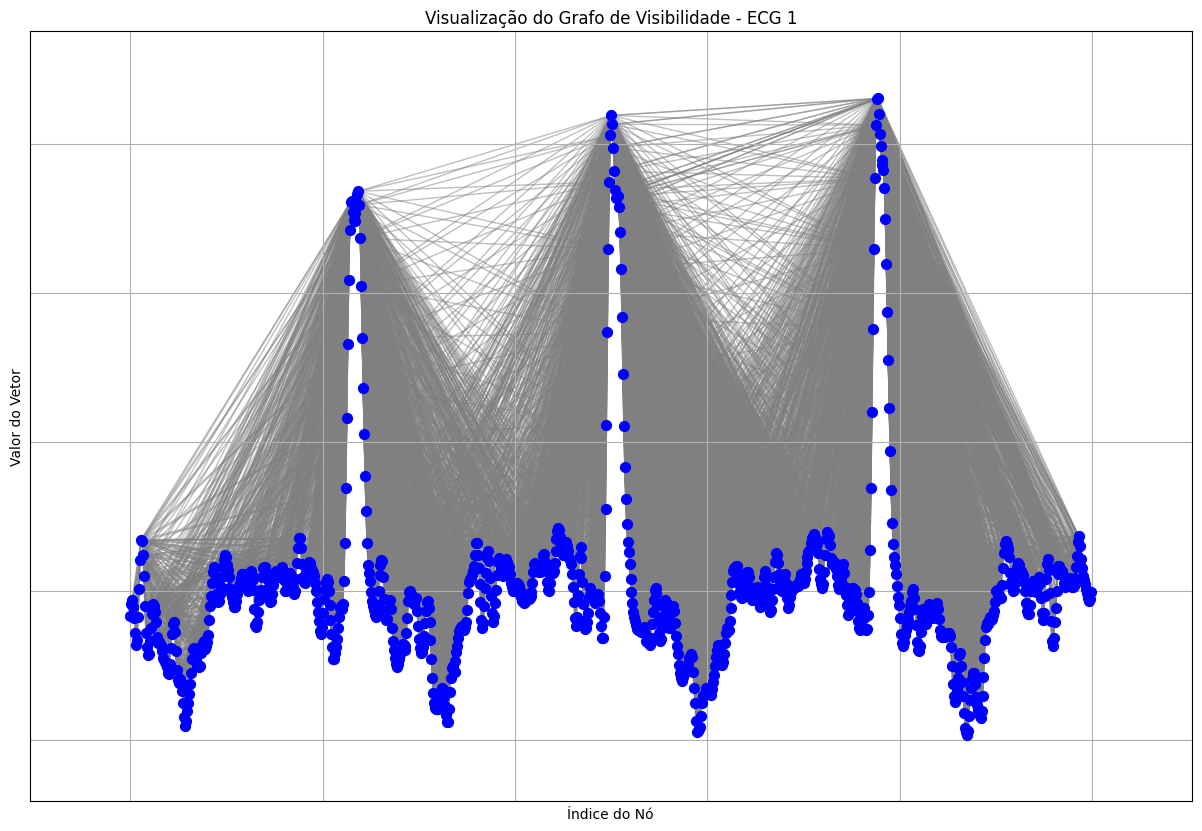

In [28]:
def visualizar_grafo_com_matplotlib(pt_path, indice):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza o grafo de um ECG especificado usando Matplotlib.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        indice (int): Índice do ECG a ser visualizado.
    """
    # Carrega os dados salvos
    try:
        dados_salvos = torch.load(pt_path)
        grafos = dados_salvos['grafos']
        vetores = dados_salvos['vetores']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    # Verifica se o índice está dentro do intervalo válido
    if indice < 0 or indice >= len(grafos):
        print(f"Índice {indice} está fora do intervalo válido (0-{len(grafos)-1}).")
        return

    grafo = grafos[indice]
    vetor = vetores[indice]

    src = grafo['src'].cpu().numpy()
    dst = grafo['dst'].cpu().numpy()

    # Verifica se o vetor tem o mesmo número de nós que esperado
    num_nodes = len(vetor)
    max_node = max(np.max(src), np.max(dst))
    if max_node >= num_nodes:
        print("Atenção: O vetor fornecido não cobre todos os nós do grafo.")
        num_nodes = max_node + 1  # Atualiza o número de nós

    # Criar o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(zip(src, dst))
    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Definir posições dos nós
    # Exemplo: x = índice do nó, y = valor do vetor
    pos = {i: (i, vetor[i]) for i in range(num_nodes)}

    # Plotar o grafo
    plt.figure(figsize=(15, 10))
    # Desenhar arestas
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    # Desenhar nós
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    # Opcional: adicionar rótulos aos nós
    # nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Visualização do Grafo de Visibilidade - ECG {indice}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Valor do Vetor")
    plt.grid(True)
    plt.show()

# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo anteriormente
    pt_path = 'autoencoder_batimentos.pt'

    # Índice do ECG a ser visualizado
    indice = 1  # Substitua pelo índice desejado

    # Chamar a função de visualização
    visualizar_grafo_com_matplotlib(pt_path, indice)

/tmp/ipykernel_1042563/4100957991.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_salvos = torch.load(pt_path)


Grafo criado com 1000 nós e 12077 arestas.


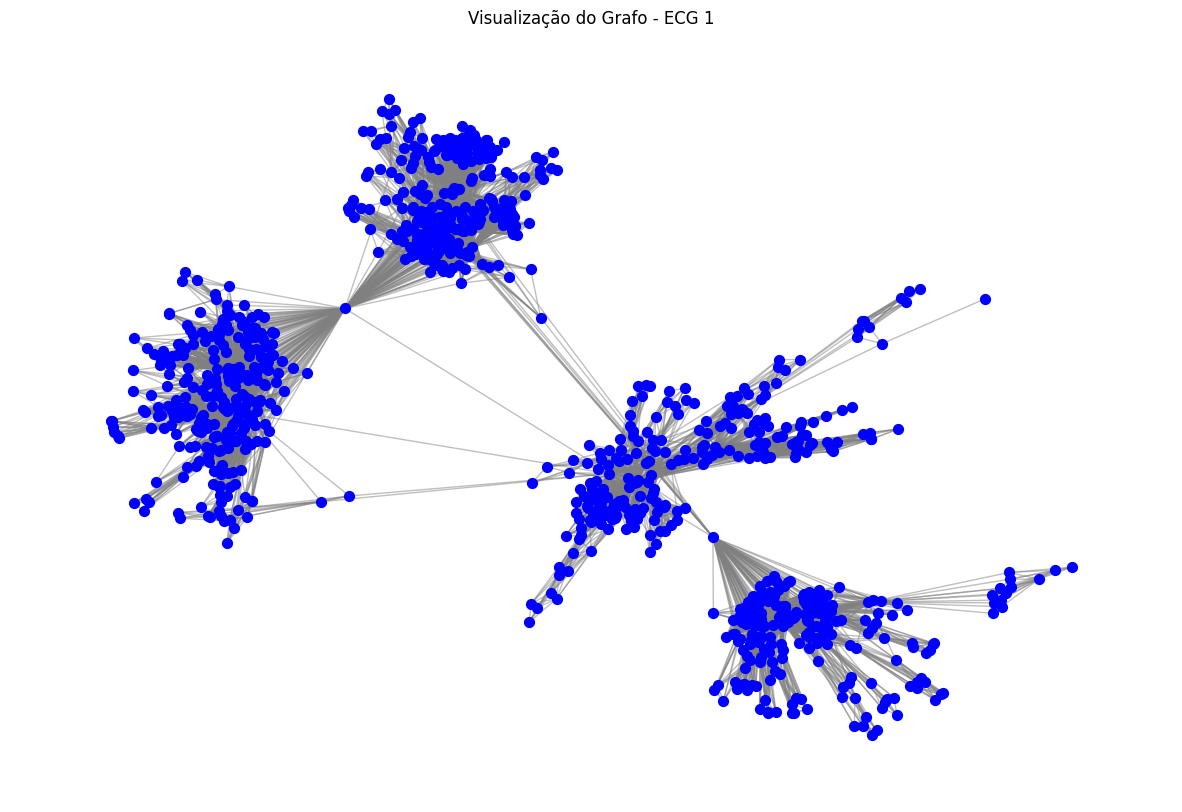

In [29]:
def visualizar_apenas_grafo_com_matplotlib(pt_path, indice):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza apenas o grafo de um ECG especificado usando Matplotlib.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        indice (int): Índice do ECG a ser visualizado.
    """
    # Carrega os dados salvos
    try:
        dados_salvos = torch.load(pt_path)
        grafos = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    # Verifica se o índice está dentro do intervalo válido
    if indice < 0 or indice >= len(grafos):
        print(f"Índice {indice} está fora do intervalo válido (0-{len(grafos)-1}).")
        return

    grafo = grafos[indice]

    src = grafo['src'].cpu().numpy()
    dst = grafo['dst'].cpu().numpy()

    # Criar o grafo com NetworkX
    G = nx.Graph()
    G.add_edges_from(zip(src, dst))
    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Usar layout automático do NetworkX para posicionar os nós
    pos = nx.spring_layout(G)

    # Plotar o grafo
    plt.figure(figsize=(15, 10))
    # Desenhar arestas
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    # Desenhar nós
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    # Opcional: adicionar rótulos aos nós
    # nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Visualização do Grafo - ECG {indice}")
    plt.axis("off")  # Remover eixos
    plt.show()

# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo anteriormente
    pt_path = 'autoencoder_batimentos.pt'

    # Índice do ECG a ser visualizado
    indice = 1  # Substitua pelo índice desejado

    # Chamar a função de visualização
    visualizar_apenas_grafo_com_matplotlib(pt_path, indice)
